In [1]:
from __future__ import division
import numpy as np
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.signal as spsig
import math
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import um_lagmodel as uml
#import um_lagmodel_old as umlold
#%matplotlib inline
%matplotlib notebook

/Users/philu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  # Remove the CWD from sys.path while we load stuff.


In [2]:
def calc_irf_centroid(irf,deltau):
    # Calculates IRF centroid lag seen by each radial bin
    irftau = np.where(deltau > 0, np.multiply((np.cumsum(deltau)-deltau/2),irf),  
                      np.multiply(np.cumsum(deltau),irf))
    return np.divide(np.cumsum(irftau),np.cumsum(irf))

def calc_irf_centroid2(irf,irf_nbins,dt):
    # Calculates IRF centroid lag seen by each radial bin
    irftau = np.where(irf_nbins > 0, np.multiply(((np.cumsum(irf_nbins)-(irf_nbins-1)/2.)*dt),irf),  
                      np.multiply((np.cumsum(irf_nbins)*dt),irf))
    return np.divide(np.cumsum(irftau),np.cumsum(irf))

def calc_flux_centroid(irf_seed,irf_heat,irf_nbins,dt,energy,e_seed,gamma_mean,gamma_ind):
    tauirf_seed = np.cumsum(np.where(irf_nbins > 0, 
                                     np.multiply(((np.cumsum(irf_nbins)-(irf_nbins-1)/2.)*dt),irf_seed), 
                           np.multiply((np.cumsum(irf_nbins)*dt),irf_seed)))
    tauirf_heat = np.cumsum(np.where(irf_nbins > 0, 
                                     np.multiply(((np.cumsum(irf_nbins)-(irf_nbins-1)/2.)*dt),irf_heat), 
                           np.multiply((np.cumsum(irf_nbins)*dt),irf_heat)))
    hlum = np.sum(irf_heat)
    slum = np.sum(irf_seed)
    u = gamma_mean*gamma_ind*(np.log(energy/e_seed)-(gamma_mean-1)**(-1))
    flux_cent = np.divide(((1-u)*tauirf_seed/slum + u*tauirf_heat/hlum),
                          ((1-u)*np.cumsum(irf_seed)/slum+u*np.cumsum(irf_heat)/hlum))
    return flux_cent

def calc_flux_lag(irf_seed,irf_heat,deltau,en1,en2,e_seed,gamma_mean,gamma_ind):
    seed_cent = calc_irf_centroid(irf_seed,deltau)
    heat_cent = calc_irf_centroid(irf_heat,deltau)
    lfrac_s = np.cumsum(irf_seed)/np.sum(irf_seed)
    lfrac_h = np.cumsum(irf_heat)/np.sum(irf_heat)
    u1 = gamma_mean*gamma_ind*(np.log(en1/e_seed) - 1/(gamma_mean-1))
    u2 = gamma_mean*gamma_ind*(np.log(en2/e_seed) - 1/(gamma_mean-1))
    denom = ((1-u2)*lfrac_s/lfrac_h + u2)*((1-u1) + u1*lfrac_h/lfrac_s)    
    flux_lag = (u1-u2)*(seed_cent-heat_cent)/denom
    return flux_lag

def calc_centroid_lags_psd(irf1,irf2,cent1,cent2,freq,lfreq,q,rms):
    # Calculates lag vs IRF bin assuming centroid approximation only
    lag_cent = cent1 - cent2
    psdmult1 = np.power(np.divide(np.cumsum(irf1),np.sum(irf1)),2)
    psdmult2 = np.power(np.divide(np.cumsum(irf2),np.sum(irf2)),2)
    lor_psd = uml.lorentz_q(freq, lfreq, q, rms)
    lor_psd1 = uml.lorentz_q(freq, lfreq, q, np.multiply(rms,np.sqrt(psdmult1)))
    lor_psd2 = uml.lorentz_q(freq, lfreq, q, np.multiply(rms,np.sqrt(psdmult2)))
    sum_psd = np.sum(lor_psd,axis=0)
    wtlag_cent = np.sum(np.multiply(np.reshape(lag_cent,[len(lag_cent),1]),lor_psd),axis=0)
    wtlag_cent = np.divide(wtlag_cent,sum_psd)
    return lag_cent,wtlag_cent,np.sum(lor_psd1,axis=0),np.sum(lor_psd2,axis=0)

def irf_plot_rebin(irf,deltau,minbin,i_rcor,i_rsigmax):
    if (np.sum(deltau[:i_rcor]) == 0.):
        tau_edges = np.zeros((i_rsigmax-i_rcor)+3)
        irf_rb = np.zeros(len(tau_edges)-1)
        tau_edges[-1:-3:-1] = [minbin,0.]
        tau_edges[-3::-1] = -1.*np.cumsum(deltau[i_rcor:i_rsigmax+1])
        irf_rb[-1] = np.sum(irf[0:i_rcor])/minbin
        irf_rb[-2::-1] = irf[i_rcor:i_rsigmax+1]/(-1.*np.diff(tau_edges[-2::-1]))
    else:
        tau_edges = np.zeros(i_rsigmax+2)
        irf_rb = np.zeros(len(tau_edges)-1)
        tau_edges[-i_rcor:] = np.cumsum(deltau[i_rcor-1::-1])
        tau_edges[-i_rcor-1] = 0.
        tau_edges[-i_rcor-2::-1] = -1.*np.cumsum(deltau[i_rcor:i_rsigmax+1])
        irf_rb = irf[i_rsigmax::-1]/np.diff(tau_edges)
    return tau_edges, irf_rb

def plot_irfs(disk_irf,seed_irf,heat_irf,flux0_irf,flux1_irf,deltau,dt,i_rcor,i_rsigmax):
    tau_edges, disk_irf_rb = irf_plot_rebin(disk_irf,deltau,dt,i_rcor,i_rsigmax)
    tau_edges, seed_irf_rb = irf_plot_rebin(seed_irf,deltau,dt,i_rcor,i_rsigmax)
    tau_edges, heat_irf_rb = irf_plot_rebin(heat_irf,deltau,dt,i_rcor,i_rsigmax)
    tau_edges, flux0_irf_rb = irf_plot_rebin(flux0_irf,deltau,dt,i_rcor,i_rsigmax)
    tau_edges, flux1_irf_rb = irf_plot_rebin(flux1_irf,deltau,dt,i_rcor,i_rsigmax)
    dummy_data = (tau_edges[1:] + tau_edges[:-1])/2.
    plt.figure()
    plt.hist(dummy_data, bins=tau_edges, weights=disk_irf_rb, histtype='step')
    plt.hist(dummy_data, bins=tau_edges, weights=seed_irf_rb, histtype='step')
    plt.hist(dummy_data, bins=tau_edges, weights=heat_irf_rb, histtype='step')
#    plt.scatter(np.diff(tau_edges[:2]),heat_irf_rb[0],marker='+')
#    plt.vlines()
    plt.yscale('log')
    plt.xscale('symlog', linthreshx=1e3, linscalex=0.5)
    plt.xlim(tau_edges[0],tau_edges[-1]+1000.)
    plt.xticks([-1e5,-1e4,-1e3,0])
    plt.show()    
    return
    


In [3]:
# Set up starting parameters:
############################################
### Basic geometry and radial binning: #####
############################################
cor_geometry = uml.an_sphere
rin = 4.0  # Innermost radius for viscous dissipation (ISCO)
rout = 300.0 # Outermost radius for viscous dissipation - best to set large but with smaller rsigmax 
# to make linear rebinned IRFs manageable
nrad = 200 # Number of radial bins for viscous dissipation
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
hcor = 10.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 45.0  # Cone opening angle in degrees
#rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
#print("Coronal top radius : ",rtop)
geopar = [rcor]
################################################################################
### 'Timing model' parameters for driving signal generation and propagation ####
################################################################################
rsigmax = 100.0 # Maximum radius for inward-propagating signals to start from
t_scale= 5e-5 # Scaling between Rg/c units and actual time units (e.g. for timing in seconds, this is Rg/c in seconds,
# e.g. 5e-5 for a 10 solar mass BH)
min_deltau_frac = 0.25 # Minimum bin size (fraction of minimum propagation delay across a bin)
disk_tau_par = [1000.,0.] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
lor_model = 'multi_radius' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.3,0.] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii
disk_prop_par = [1000.,0.] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [0., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

nirf_mult = 8 # IRF is this (must be power of 2) times bigger than next highest power of 2 bins corresponding to 
#  propagation time from max. signal radius.  Set high enough to ensure entire useful frequency range can be covered.

###########################################################################################
### 'Spectral model' parameters for disk absorbed flux and seed and heating in corona, ####
### photon index dependence on L_s/L_h and choice of energies for power-law fluxes and ####
### observed disk band. ###################################################################
###########################################################################################

disk_abs_frac = 0.7 # Fraction of incident flux on disk which is reprocessed into blackbody emission (= 1-albedo)
heatff_norm = 1.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into heating the corona (heat_frac_flow)
heatff_ind = 0.0 # Index for radial dependence of heat_frac_flow 
seedff_norm = 0.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into internal seed photons (seed_frac_flow)
# should be set to zero if using full energy-dependent model, as assumed internal seed spectrum 
# not yet implemented. Set to < 0 if you require seed_frac_flow = 1.-heat_frac_flow
seedff_ind = 0.0 # Index for radial dependence of seed_frac_flow 
gamma_par = [2.33,0.167] # gamma = gamma_par[0]*(L_s/L_h)^(gamma_par[1])


In [4]:
#First set up radial grid
rad_edge = np.logspace(np.log10(rin), np.log10(rout), nrad+1)  # set up radial bin edges
rad = np.sqrt(rad_edge[1:]*rad_edge[:-1])  # Define radial bin centres as geometric mean of bin edges
rad_area = np.pi*(np.square(rad_edge[1:])-np.square(rad_edge[:-1]))
disp_frac, seed_frac_flow, heat_frac_flow = \
    uml.calc_dispfrac(rad,rad_edge,rad_area,seedff_norm,seedff_ind,heatff_norm,heatff_ind) 

# Normalised viscous dissipation and parameters for seed and heating fractions within coronal flow.

# Now reset coronal outer radius (i.e. disk inner radius) to be at the nearest radial bin edges
rcor, i_rcor = uml.find_nearest(rad_edge,rcor)

# Reset maximum signal radius to nearest radial bin value
rsigmax, i_rsigmax = uml.find_nearest(rad,rsigmax)
print("Coronal radius reset to nearest radial bin edge: ",rcor)
print("Maximum signal radius reset to: ",rsigmax)

# Calculate illumination of corona by disk and vice-versa
omega_cor, disktocor_frac, cortodisk_frac = uml.calc_illumination_fracs(rad,rad_area,cor_geometry,geopar)

cortodisk_frac = disk_abs_frac*cortodisk_frac   # Account for disk albedo (1-disk_abs_frac)

print(np.sum(disp_frac[i_rcor:]*disktocor_frac[i_rcor:])/np.sum(disp_frac[i_rcor:])," of the disk flux is intercepted by the corona")
print(np.sum(cortodisk_frac[i_rcor:])," of the coronal flux is intercepted by the disk")

# Now calculate radial dependence of timing parameters and calculate propagation delays
tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)

deltau = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)
# Calculate the radially-dependent direct disk, seed photon and coronal heating luminosities
ldisk_disp, lseed_disp, lheat, ldisk_rev, lseed_rev =\
    uml.calc_radial_time_response(rad,i_rcor,disp_frac,disktocor_frac,cortodisk_frac,seed_frac_flow,heat_frac_flow)

# Assign maximum kT, seed energy for monochromatic seeds (analytical model), kT vs radius and total disk L
kT_max = 0.3
e_seed = 2.82*kT_max
kT, ldisk_tot = uml.kT_rad_calc(kT_max,rad_area,ldisk_disp,lseed_disp,lheat,cortodisk_frac)

print("Seed energy :",e_seed)
print("Dissipation disk luminosity: ",np.sum(ldisk_disp))
print("Dissipation seed luminosity: ",np.sum(lseed_disp))
print("Coronal heating luminosity: ",np.sum(lheat))
print("Disk luminosity due to heating by corona: ",np.sum(ldisk_rev))
print("Seed luminosity due to heating by corona: ",np.sum(lseed_rev))

Coronal radius reset to nearest radial bin edge:  9.90427879182065
Maximum signal radius reset to:  100.84823126666652
0.06192303763374646  of the disk flux is intercepted by the corona
0.17344113121336296  of the coronal flux is intercepted by the disk
Seed energy : 0.846
Dissipation disk luminosity:  0.6866920197492337
Dissipation seed luminosity:  0.04252205578172516
Coronal heating luminosity:  0.31330798025076645
Disk luminosity due to heating by corona:  0.06171556396916704
Seed luminosity due to heating by corona:  0.00650000799592738


Mean gamma is: 1.7093227913640812
#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  0.00854841042875955
The maximum propagation delay is:  33.26956141156627  and there are  32768  irf bins.
CI mean, ref mean, CI outer, ref outer :  0.9999999090952458 0.7483925450590837 0.000145005033875995 0.06774671974020567
Calculated for energies  [1 0]
CI mean, ref mean, CI outer, ref outer :  0.9999999325173432 0.9999999090952458 0.00010764370920324108 0.000145005033875995
Calculated for energies  [2 1]
CI mean, ref mean, CI outer, ref outer :  0.9999999528450604 0.9999999325173432 7.521832822503531e-05 0.00010764370920324108
Calculated for energies  [3 2]
CI mean, ref mean, CI outer, ref outer :  0.9999999731727769 0.9999999528450604 4.2792947246829545e-05 7.521832822503531e-05
Calculated for energies  [4 3]
#######################################
rms =  0.1
#######################################
Calculating mono-energetic spectral-

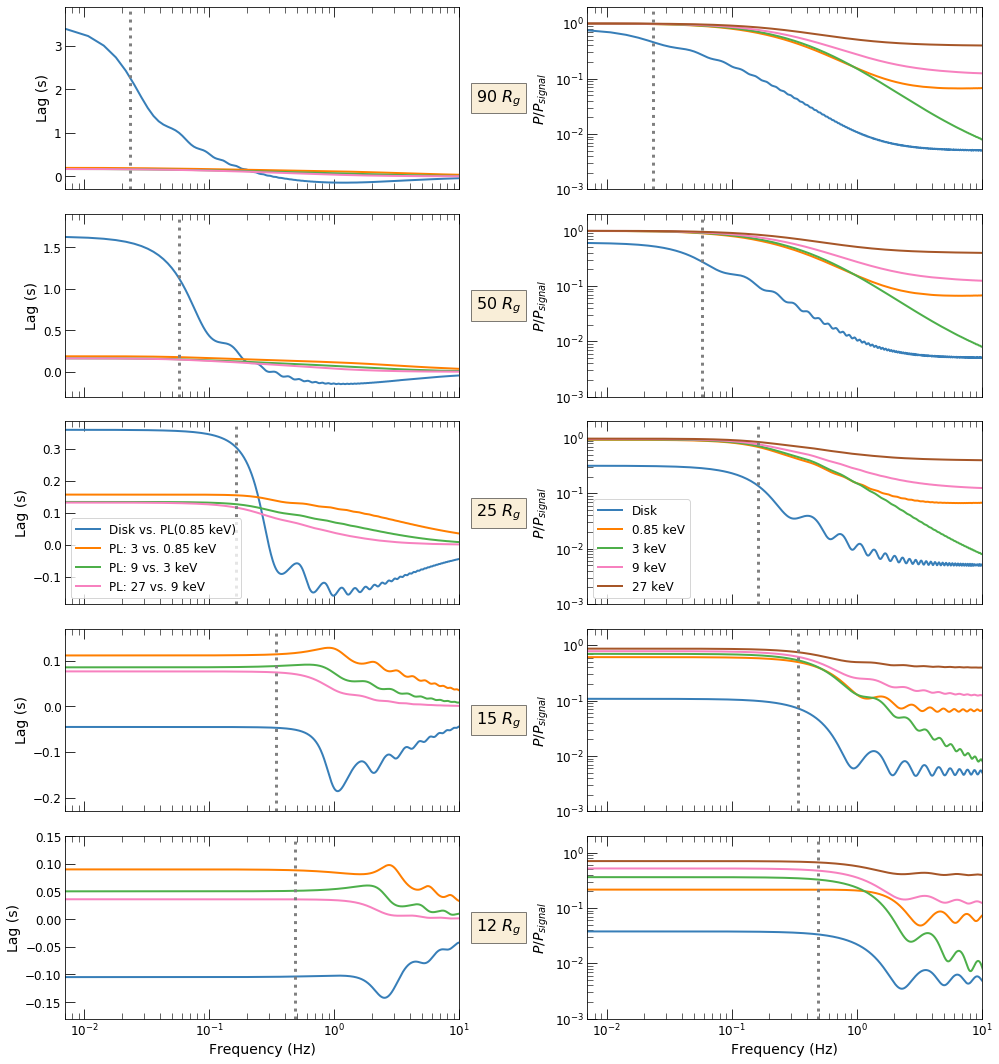

In [5]:
# Choose power-law energies for analytical calculation using mono-energetic bands 
# (must be equal or greater than e_seed):
ens_mono = np.array([e_seed,3.0,9.0,27.0])

# Calculate IRFs for the mono-energetic case
gamma_mean, gamma_irf, flux_irf_mono, disk_irf_mono, seed_irf_mono =\
                    uml.calc_irfs_mono(rad,gamma_par,e_seed,ens_mono,\
                                ldisk_disp,lseed_disp,lheat,ldisk_rev,lseed_rev)
print("Mean gamma is:", gamma_mean)


# Specify pairs of energy bands to use for spectral-timing measurements. Band 0 is the disk, larger indices
# i corresponds to index i-1 in the array of monoenergetic bands for power-law analysis.
#encomb = np.array([[1,0],[2,1],[3,1],[4,1]]) # Set array of energy combinations for spectral-timing outputs
encomb = np.array([[1,0],[2,1],[3,2],[4,3]])

sigrad = [90.0,50.0,25.0,15.0,12.0]
i = 0
for i in range(len(sigrad)):
    lor_par = [sigrad[i],100.0,0.1]
    tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)
    
    # Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
    freq, phlag, tlag, psd_ci, psd_ref, mod_sig_psd, irf_nbins, irf_binedgefrac, deltau_scale, dt, nirf,\
        ci_irf, ci_mean, ci_outer =\
    uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf_mono,disk_irf_mono,gamma_irf,
                              deltau,min_deltau_frac,i_rsigmax,lfreq,q,rms,t_scale)
    if (i == 0):
       lag_arr = np.zeros((len(sigrad),len(encomb),len(freq)))
       psd_ci_arr = np.zeros((len(sigrad),len(encomb),len(freq)))
       psd_ref_arr = np.zeros((len(sigrad),len(encomb),len(freq)))
       mod_sig_psd_arr = np.zeros((len(sigrad),len(freq)))
    lag_arr[i,:,:] = tlag[:,:]
    psd_ci_arr[i,:,:] = psd_ci[:,:]
    psd_ref_arr[i,:,:] = psd_ref[:,:]
    mod_sig_psd_arr[i,:] = mod_sig_psd
    rsig, i_rsig = uml.find_nearest(rad,sigrad[i])
    print("rms = ",rms[i_rsig])


CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # Colour palette better for range of colour-blindness
    
fig, axes = plt.subplots(5,2, figsize=(14,15),sharex=True)
props = dict(boxstyle='square', facecolor='wheat', alpha=0.5)
#fig.subplots_adjust(hspace=0)
i = 0
for ax in axes[:,0]:    
    rsig, i_rsig = uml.find_nearest(rad,sigrad[i])
    ax.plot(freq, lag_arr[i,0,:], color=CBcol[0],linewidth=2,label='Disk vs. PL(0.85 keV)')
    ax.plot(freq, lag_arr[i,1,:], color=CBcol[1],linewidth=2,label='PL: 3 vs. 0.85 keV')
    ax.plot(freq, lag_arr[i,2,:], color=CBcol[2],linewidth=2,label='PL: 9 vs. 3 keV')
    ax.plot(freq, lag_arr[i,3,:], color=CBcol[3],linewidth=2,label='PL: 27 vs. 9 keV')
    radtxt = str(round(sigrad[i]))+" $R_{g}$"
    ax.text(1.1, 0.5, radtxt, horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontsize=16, bbox=props)
    if i == 2:
        ax.legend(fontsize=12)
    ax.set_xscale('log')
    ax.set_ylabel("Lag (s)", fontsize=14)
    ax.axvline(1./(tau[i_rsig]*t_scale),color='gray',linewidth=3,linestyle='dotted')
#    ax.axvspan(1./(t_scale*tau[i_rcor]), 12.0, alpha=0.5, color='lightgray')
    ax.tick_params(labelsize=12, which='both', direction='in', top=True)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=6)
    i += 1
axes[-1,0].set_xlabel("Frequency (Hz)", fontsize=14)
axes[0,0].set_ylim(-0.3,3.9)
axes[1,0].set_ylim(-0.3,1.9)
axes[3,0].set_ylim(-0.23,0.17)
axes[4,0].set_ylim(-0.18,0.15)

i = 0
for ax in axes[:,1]:    
    rsig, i_rsig = uml.find_nearest(rad,sigrad[i])
    ax.plot(freq, np.divide(psd_ref_arr[i,0,:],mod_sig_psd_arr[i,:]), color=CBcol[0],linewidth=2,label='Disk')
    ax.plot(freq, np.divide(psd_ci_arr[i,0,:],mod_sig_psd_arr[i,:]), color=CBcol[1],linewidth=2,label='0.85 keV')
    ax.plot(freq, np.divide(psd_ci_arr[i,1,:],mod_sig_psd_arr[i,:]), color=CBcol[2],linewidth=2,label='3 keV')
    ax.plot(freq, np.divide(psd_ci_arr[i,2,:],mod_sig_psd_arr[i,:]), color=CBcol[3],linewidth=2,label='9 keV')
    ax.plot(freq, np.divide(psd_ci_arr[i,3,:],mod_sig_psd_arr[i,:]), color=CBcol[4],linewidth=2,label='27 keV')
    if i == 2:
        ax.legend(fontsize=12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel("$P/P_{signal}$", fontsize=14)
    ax.axvline(1./(tau[i_rsig]*t_scale),color='gray',linewidth=3,linestyle='dotted')
#    ax.axvspan(1./(t_scale*tau[i_rcor]), 12.0, alpha=0.5, color='lightgray')
    ax.tick_params(labelsize=12, which='both', direction='in', top=True)
    ax.tick_params(which='major', length=10)
    ax.tick_params(which='minor', length=6)
    ax.set_ylim(1e-3,2.0)
    i += 1
axes[-1,1].set_xlabel("Frequency (Hz)", fontsize=14)
plt.xlim(0.007,10.0)
plt.tight_layout(pad=1.5)
#plt.savefig('figs/lagpsd_5radii_spherical_monoseed_10rg.pdf',bbox_inches='tight')
plt.show()


#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  0.00854841042875955
The maximum propagation delay is:  33.26956141156627  and there are  32768  irf bins.
CI mean, ref mean, CI outer, ref outer :  0.9999999090952458 0.7483925450590837 0.000145005033875995 0.06774671974020567
Calculated for energies  [1 0]
CI mean, ref mean, CI outer, ref outer :  0.9999999325173432 0.9999999090952458 0.00010764370920324108 0.000145005033875995
Calculated for energies  [2 1]
CI mean, ref mean, CI outer, ref outer :  0.9999999528450604 0.9999999325173432 7.521832822503531e-05 0.00010764370920324108
Calculated for energies  [3 2]
CI mean, ref mean, CI outer, ref outer :  0.9999999731727769 0.9999999528450604 4.2792947246829545e-05 7.521832822503531e-05
Calculated for energies  [4 3]
#######################################


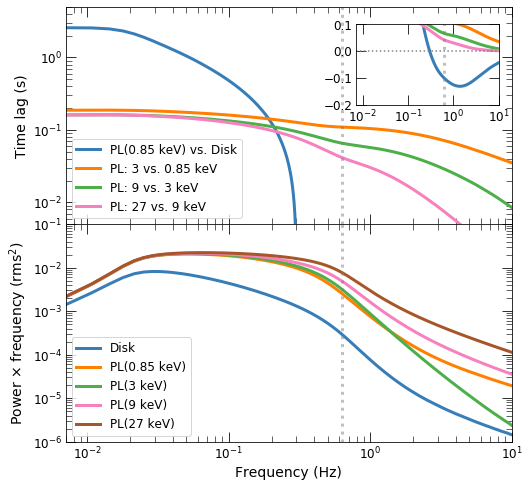

In [12]:
disk_tau_par = [1000.,0.] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
disk_prop_par = [1000.,0.] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [0., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

lor_model = 'continuous' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.3,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii

tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)
deltau = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)

# Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
freq, phlag, tlag, psd_ci, psd_ref, mod_sig_psd, irf_nbins, irf_binedgefrac, deltau_scale, dt, nirf,\
        ci_irf, ci_mean, ci_outer =\
    uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf_mono,disk_irf_mono,gamma_irf,
                              deltau,min_deltau_frac,i_rsigmax,lfreq,q,rms,t_scale)


# Now set up plot parameters and make the plot:
freqlim = [0.007,10.0]
freqticks = [0.01,0.1,1,10]
axis_names = ['Frequency (Hz)','Time lag (s)',r'Power $\times$ frequency (rms$^{2}$)']
legend_title = None
laglim = [0.005,5]
psdlim = [1e-6,0.1]
laglim_inset = [-0.2,0.1]
yticks_inset = [-0.2,-0.1,0,0.1]
vlines_list = [[1./(tau[i_rcor]*t_scale),'gray','dotted']]

lag_labels_edep = ['PL(0.85 keV) vs. Disk','PL: 3 vs. 0.85 keV','PL: 9 vs. 3 keV','PL: 27 vs. 9 keV']
psd_labels_edep = ['Disk','PL(0.85 keV)','PL(3 keV)','PL(9 keV)','PL(27 keV)']

lags_list = []
psds_list = []
psds_list.append([freq,freq*psd_ref[0,:],CBcol[0],'solid',psd_labels_edep[0]])
for i in range(len(encomb)):
    lags_list.append([freq,tlag[i,:],CBcol[i],'solid',lag_labels_edep[i]])
    psds_list.append([freq,freq*psd_ci[i,:],CBcol[i+1],'solid',psd_labels_edep[i+1]])

#figfile='figs/lagspsd_spherical_monoseed_10rg.pdf'
figfile=None

uml.plot_lags_psds(lags_list,psds_list,vlines_list,freqlim,freqticks,laglim,psdlim,laglim_inset,yticks_inset,
                   axis_names,legend_title,figfile)


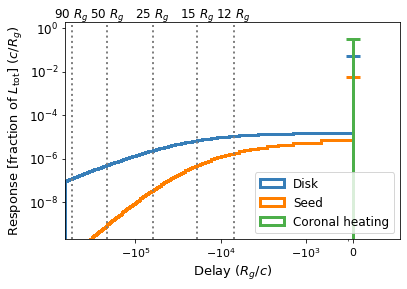

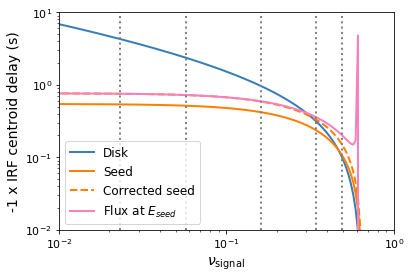

In [7]:
def lagcentnew(seed_irf,heat_irf,deltau_scale,e1,e2,e_seed,gamma_mean,gamma_ind):
    seed_cent = calc_irf_centroid(seed_irf,deltau_scale)
    heat_cent = calc_irf_centroid(heat_irf,deltau_scale)
    u1 = gamma_mean*gamma_ind*(np.log(e1/e_seed)-(gamma_mean-1)**(-1))
    u2 = gamma_mean*gamma_ind*(np.log(e2/e_seed)-(gamma_mean-1)**(-1))
    f_s = np.cumsum(seed_irf)/np.sum(seed_irf)
    f_h = np.cumsum(heat_irf)/np.sum(heat_irf)
#    centlag = (u2-u1)*(seed_cent-heat_cent)/(((1-u2)*f_s+u2*f_h)*((1-u1)*f_s+u1*f_h))   
    centlag = (u2-u1)*(seed_cent-heat_cent)/(((1-u2)*f_s/f_h + u2)*((1-u1) + u1*f_h/f_s))
    return centlag

def deltairfcalc(seed_irf,heat_irf,deltau_scale,ens,e_seed,gamma_mean,gamma_ind):
    seed_delta = np.sum(seed_irf[deltau_scale == 0])
    heat_delta = np.sum(heat_irf[deltau_scale == 0])
    u = gamma_mean*gamma_ind*(np.log(ens/e_seed)-(gamma_mean-1)**(-1))
    f_s = seed_delta/np.sum(seed_irf)
    f_h = heat_delta/np.sum(heat_irf)
    return (1-u)*f_s +u*f_h

def denomcalc(seed_irf,heat_irf,deltau_scale,e1,e2,e_seed,gamma_mean,gamma_ind):
    seed_cent = calc_irf_centroid(seed_irf,deltau_scale)
    heat_cent = calc_irf_centroid(heat_irf,deltau_scale)
    u1 = gamma_mean*gamma_ind*(np.log(e1/e_seed)-(gamma_mean-1)**(-1))
    u2 = gamma_mean*gamma_ind*(np.log(e2/e_seed)-(gamma_mean-1)**(-1))
    f_s = np.cumsum(seed_irf)/np.sum(seed_irf)
    f_h = np.cumsum(heat_irf)/np.sum(heat_irf)
#    centlag = (u2-u1)*(seed_cent-heat_cent)/(((1-u2)*f_s+u2*f_h)*((1-u1)*f_s+u1*f_h))   
    denom = (((1-u2)*f_s/f_h + u2)*((1-u1) + u1*f_h/f_s))
    return denom


def plot_irfs(disk_irf,seed_irf,heat_irf,deltau,minbin,i_rcor,i_rsigmax,sigrad,rad):
    tau_edges, disk_irf_rb = irf_plot_rebin(disk_irf,deltau,minbin,i_rcor,i_rsigmax)
    tau_edges, seed_irf_rb = irf_plot_rebin(seed_irf,deltau,minbin,i_rcor,i_rsigmax)
    tau_edges, heat_irf_rb = irf_plot_rebin(heat_irf,deltau,minbin,i_rcor,i_rsigmax)
    dummy_data = (tau_edges[1:] + tau_edges[:-1])/2.
    CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # Colour palette better for range of colour-blindness
    plt.figure()
    disk_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=disk_irf_rb, histtype='step',
                                         linewidth=3,color=CBcol[0],label='Disk')
    seed_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=seed_irf_rb, histtype='step',
                                         linewidth=3,color=CBcol[1],label='Seed')
    heat_bins, edges, patches = plt.hist(dummy_data, bins=tau_edges, weights=heat_irf_rb, histtype='step',
                                         linewidth=3,color=CBcol[2],label='Coronal heating')
    plt.scatter(np.mean(tau_edges[-2:]),disk_irf_rb[-1],marker='_',s=200,
                linewidth=3,color=CBcol[0])
    plt.scatter(np.mean(tau_edges[-2:]),seed_irf_rb[-1],marker='_',s=200,
                linewidth=3,color=CBcol[1])
    plt.scatter(np.mean(tau_edges[-2:]),heat_irf_rb[-1],marker='_',s=200,
                linewidth=3,color=CBcol[2])
    plt.yscale('log')
    plt.xscale('symlog', linthreshx=1e3, linscalex=0.5)
    plt.xlim(-1.*np.sum(deltau[i_rcor:i_rsigmax+1]),np.sum(deltau[:i_rcor])+1000.)
    plt.ylim(2e-10,2.0)
    plt.xticks([-1e5,-1e4,-1e3,0],fontsize=11) 
    plt.yticks(fontsize=12)
    plt.xlabel('Delay ($R_g/c$)', fontsize=13)
    plt.ylabel(r'Response [fraction of $L_{\rm tot}$] ($c/R_g$)', fontsize=13)
    for radius in sigrad:
        rsig, i_rsig = uml.find_nearest(rad,radius)
        tausig = np.sum(deltau[:i_rsig+1])
        plt.axvline(-1.*tausig,color='gray',linestyle='dotted',linewidth=2)
        radtxt = str(round(radius))+" $R_{g}$"
        plt.text(-1.*tausig,3.0,radtxt,fontsize=12,horizontalalignment='center')
    plt.legend(fontsize=12)
#    plt.savefig('figs/irf_5radii_spherical_monoseed_10rg.pdf',bbox_inches='tight')
    plt.show()    
    return

def plot_disk_seed_centroids(disk_irf,seed_irf,flux_irf,deltau_scale,lfreq,rad,sigrad,gamma_mean,gamma_ind,
                             en,e_seed):
    disk_cent = calc_irf_centroid(disk_irf,deltau_scale)
    seed_cent = calc_irf_centroid(seed_irf,deltau_scale)
    flux_cent = calc_irf_centroid(flux_irf,deltau_scale) 
    CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00'] # Colour palette better for range of colour-blindness
    plt.figure()
    plt.plot(lfreq,disk_cent,linewidth=2,color=CBcol[0],label='Disk')
    plt.plot(lfreq,seed_cent,linewidth=2,color=CBcol[1],label='Seed')    
    plt.plot(lfreq,seed_cent*(1+(gamma_mean*gamma_ind/(gamma_mean-1))),linewidth=2,color=CBcol[1],
             label='Corrected seed',linestyle='dashed')
    plt.plot(lfreq,flux_cent,linewidth=2,color=CBcol[3],label='Flux at $E_{seed}$')
    u = gamma_mean*gamma_ind*(np.log(en/e_seed)-(gamma_mean-1)**(-1))
    lfrac = 1./(np.cumsum(seed_irf)/np.sum(seed_irf))
#    plt.plot(lfreq,seed_cent*(1-u)/(1+u*(lfrac-1)),color='magenta',linewidth=3,linestyle='dotted')
    for radval in sigrad:
        rsig, i_rsig = uml.find_nearest(rad,radval)
        plt.axvline(lfreq[i_rsig],color='gray',linewidth=2,linestyle='dotted')
    plt.xlabel(r'$\nu_{\rm signal}$',fontsize=14)
    plt.ylabel('-1 x IRF centroid delay (s)', fontsize=14)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.01,1.0)
    plt.ylim(0.01,10.0)
    plt.legend(fontsize=12)
#    plt.savefig('figs/irf_centroidvslfreq_spherical_monoseed_10rg.pdf',bbox_inches='tight')
    plt.show()
    return


plot_irfs((ldisk_disp+ldisk_rev),(lseed_disp+lseed_rev),lheat,deltau,1.0,i_rcor,i_rsigmax,sigrad,rad)
plot_disk_seed_centroids((ldisk_disp+ldisk_rev),(lseed_disp+lseed_rev),flux_irf_mono[0,:],deltau_scale,lfreq,rad,
                         sigrad,gamma_mean,gamma_par[1],ens_mono[0],e_seed)



#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  0.00854841042875955
The maximum propagation delay is:  33.26956141156627  and there are  32768  irf bins.
CI mean, ref mean, CI outer, ref outer :  0.9999999090952458 0.7483925450590837 0.000145005033875995 0.06774671974020567
Calculated for energies  [1 0]
CI mean, ref mean, CI outer, ref outer :  0.9999999325173432 0.9999999090952458 0.00010764370920324108 0.000145005033875995
Calculated for energies  [2 1]
CI mean, ref mean, CI outer, ref outer :  0.9999999528450604 0.9999999325173432 7.521832822503531e-05 0.00010764370920324108
Calculated for energies  [3 2]
CI mean, ref mean, CI outer, ref outer :  0.9999999731727769 0.9999999528450604 4.2792947246829545e-05 7.521832822503531e-05
Calculated for energies  [4 3]
#######################################
#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  0.00085

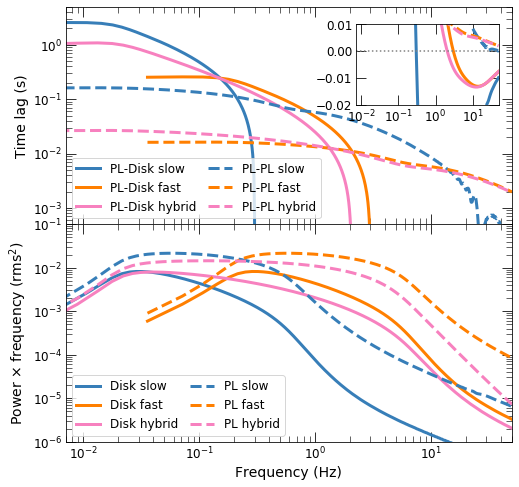

In [11]:
disk_tau_par = [1000.,0.] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
disk_prop_par = [1000.,0.] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [0., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

lor_model = 'continuous' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.3,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii

tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)
deltau = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)

# Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
freq_ss, phlag, tlag_ss, psd_ci_ss, psd_ref_ss, mod_sig_psd, irf_nbins, irf_binedgefrac, deltau_scale, dt, nirf,\
        ci_irf, ci_mean, ci_outer =\
    uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf_mono,disk_irf_mono,gamma_irf,
                              deltau,min_deltau_frac,i_rsigmax,lfreq,q,rms,t_scale)
tau_ss = 1.*tau

disk_tau_par = [100.,0.] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
disk_prop_par = [100.,0.] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [0., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

lor_model = 'continuous' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.3,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii

tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)
deltau = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)
tau_ff = 1.*tau

# Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
freq_ff, phlag, tlag_ff, psd_ci_ff, psd_ref_ff, mod_sig_psd, irf_nbins, irf_binedgefrac, deltau_scale, dt, nirf,\
        ci_irf, ci_mean, ci_outer =\
    uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf_mono,disk_irf_mono,gamma_irf,
                              deltau,min_deltau_frac,i_rsigmax,lfreq,q,rms,t_scale)

disk_tau_par = [100.,1.0] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
disk_prop_par = [100.,1.0] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [0., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

lor_model = 'continuous' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.3,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii

tau, lfreq, q, rms = uml.calc_timing_params(rad, i_rsigmax, rcor, i_rcor, t_scale, disk_tau_par, cor_tau_par,\
                                        lor_model, lor_par)
deltau = uml.calc_propagation_params(rad,rad_edge,rcor,i_rcor,disk_prop_par,cor_prop_par)

# Calculate frequency-dependent spectral-timing products using the mono-energetic calculation
freq_sf, phlag, tlag_sf, psd_ci_sf, psd_ref_sf, mod_sig_psd, irf_nbins, irf_binedgefrac, deltau_scale, dt, nirf,\
        ci_irf, ci_mean, ci_outer =\
    uml.calculate_stprod_mono(nirf_mult,ens_mono,encomb,flux_irf_mono,disk_irf_mono,gamma_irf,
                              deltau,min_deltau_frac,i_rsigmax,lfreq,q,rms,t_scale)



# Now set up plot parameters and make the plot:
freqlim = [0.007,50.0]
freqticks = [0.01,0.1,1,10]
axis_names = ['Frequency (Hz)','Time lag (s)',r'Power $\times$ frequency (rms$^{2}$)']
legend_title = None
laglim = [0.0005,5]
psdlim = [1e-6,0.1]
laglim_inset = [-0.02,0.01]
yticks_inset = [-0.02,-0.01,0,0.01]
vlines_list = None

lags_list = [[freq_ss,tlag_ss[0,:],CBcol[0],'solid','PL-Disk slow'],
             [freq_ff,tlag_ff[0,:],CBcol[1],'solid','PL-Disk fast'],
             [freq_sf,tlag_sf[0,:],CBcol[3],'solid','PL-Disk hybrid'],
             [freq_ss,tlag_ss[2,:],CBcol[0],'dashed','PL-PL slow'],
             [freq_ff,tlag_ff[2,:],CBcol[1],'dashed','PL-PL fast'],
             [freq_sf,tlag_sf[2,:],CBcol[3],'dashed','PL-PL hybrid']]

psds_list = [[freq_ss,freq_ss*psd_ref_ss[0,:],CBcol[0],'solid','Disk slow'],
             [freq_ff,freq_ff*psd_ref_ff[0,:],CBcol[1],'solid','Disk fast'],
             [freq_sf,freq_sf*psd_ref_sf[0,:],CBcol[3],'solid','Disk hybrid'],
             [freq_ss,freq_ss*psd_ci_ss[2,:],CBcol[0],'dashed','PL slow'],
             [freq_ff,freq_ff*psd_ci_ff[2,:],CBcol[1],'dashed','PL fast'],
             [freq_sf,freq_sf*psd_ref_sf[2,:],CBcol[3],'dashed','PL hybrid']]

#figfile='figs/lagspsd_sphmono_speedcomp_10rg.pdf'
figfile=None

uml.plot_lags_psds(lags_list,psds_list,vlines_list,freqlim,freqticks,laglim,psdlim,laglim_inset,yticks_inset,
                   axis_names,legend_title,figfile)


